## Importing Libraries and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import joblib


In [2]:
fake_df = pd.read_csv('fake.csv')
real_df = pd.read_csv('real.csv')

fake_df.head()

,tweet
0,"the tongue of his condition, now i saw things ..."
1,"by god the great, after i saw the derby of wyd..."
2,"believe in god, this zamalek fans are as good ..."
3,the coach appeared in the media and told the t...
4,asno smito\nwhoever knows her tells me a massa...


In [3]:
real_df.head()

,tweet
0,sun downs technical director: al-ahly respecte...
1,shawky gharib after the tie with enppi: our go...
2,"egyptian sports news today, wednesday 1/25/202..."
3,the main referees committee of the egyptian fo...
4,"haji bari, the striker of the future team, is ..."


## Merging two datasets into one, labeling them fake or not

In [4]:
fake_df['fakenews'] = 1
real_df['fakenews'] = 0

df = pd.concat([fake_df, real_df])
df.head()

,tweet,fakenews
0,"the tongue of his condition, now i saw things ...",1
1,"by god the great, after i saw the derby of wyd...",1
2,"believe in god, this zamalek fans are as good ...",1
3,the coach appeared in the media and told the t...,1
4,asno smito\nwhoever knows her tells me a massa...,1


In [5]:
df.isnull().sum()


tweet       17
fakenews     0
dtype: int64

In [6]:
df.dropna(inplace = True)

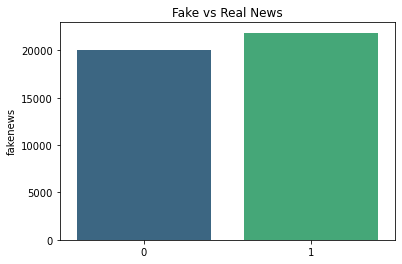

In [7]:
sns.barplot(x = df['fakenews'].unique(), y = df['fakenews'].value_counts(), palette= 'viridis')
plt.title('Fake vs Real News')
plt.show();


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41851 entries, 0 to 21868
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet     41851 non-null  object
 1   fakenews  41851 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 980.9+ KB


## Text Conversion

In [9]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def text_clean(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove text within square brackets, URLs, non-alphanumeric characters, and words containing numbers
    text = re.sub("\[.*?\]", " ", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("[^a-zA-Z\s]+", "", text)
    text = re.sub('\w*\d\w*', '', text)

    # Tokenize the text
    words = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    
    # Initialize stemmer and lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    # Apply stemming and lemmatization
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    
    # Remove duplicate tokens while preserving order
    seen = set()
    unique_lemmatized_words = [x for x in lemmatized_words if not (x in seen or seen.add(x))]
    
    # Join the words back into a single string
    text = ' '.join(unique_lemmatized_words)
    
    return text, unique_lemmatized_words

# Apply the function to the 'tweet' column in the dataframe and split the result into 'tweet' and 'tokens' columns
df['tweet'], df['tokens'] = zip(*df['tweet'].apply(text_clean))

df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mgprivate/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mgprivate/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mgprivate/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,tweet,fakenews,tokens
0,tongu condit saw thing confus shame young haha...,1,"[tongu, condit, saw, thing, confus, shame, you..."
1,god great saw derbi wydad alraja almaghribi be...,1,"[god, great, saw, derbi, wydad, alraja, almagh..."
2,believ god zamalek fan good swear celebr u too...,1,"[believ, god, zamalek, fan, good, swear, celeb..."
3,coach appear medium told truth got swear right,1,"[coach, appear, medium, told, truth, got, swea..."
4,asno smito whoever know tell massag doesnt lea...,1,"[asno, smito, whoever, know, tell, massag, doe..."


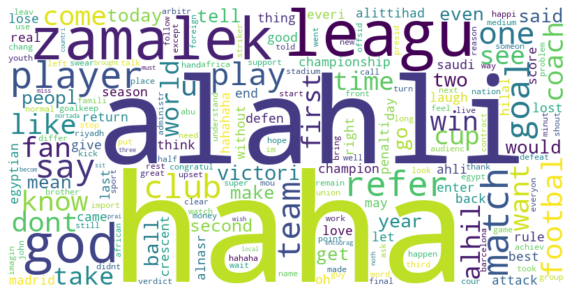

In [10]:
def visualize_most_common_words(df, fake_news_value):
    # Apply the text_clean function to the 'tweet' column and split the result into 'tweet' and 'tokens' columns
    df['tweet'], df['tokens'] = zip(*df['tweet'].apply(text_clean))
    
    # Extract tokens where fakenews equals the specified value
    tokens = df[df['fakenews'] == fake_news_value]['tokens']
    tokens = [word for token_list in tokens for word in token_list]
    
    # Count the frequency of each token
    word_freq = Counter(tokens)
    
    # Generate a word cloud from the frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


visualize_most_common_words(df, 1)

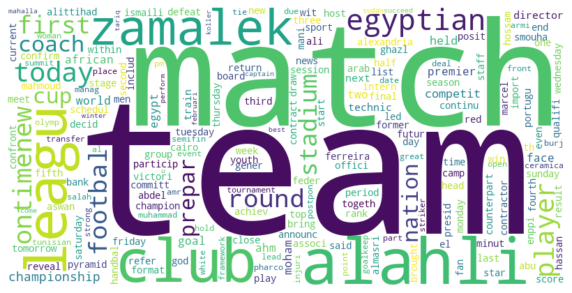

In [11]:
visualize_most_common_words(df, 0)

## Model training

Transforming text data into numerical representation using TF-IDF, enabling the model to understand the text. Then we are training the Naive Bayes model on the training set using the transformed data.

CLassification Report :

              precision    recall  f1-score   support

        Real       0.95      0.92      0.94      4373
        Fake       0.92      0.95      0.93      3998

    accuracy                           0.94      8371
   macro avg       0.94      0.94      0.94      8371
weighted avg       0.94      0.94      0.94      8371

Confusion Matrix :

[[4023  350]
 [ 191 3807]]


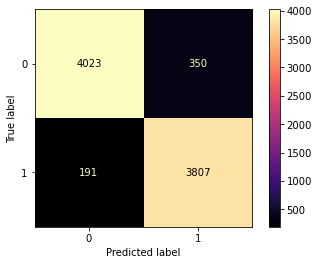

In [12]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('fakenews', axis = 1), df['fakenews'],
                                                    test_size=0.2, random_state=42, stratify = df['fakenews'])

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train['tweet'])

# Transform the test set
tfidf_test = tfidf_vectorizer.transform(X_test['tweet'])

nb = MultinomialNB()
nb.fit(tfidf_train, y_train)

y_pred = nb.predict(tfidf_test)

print('CLassification Report :\n')
print(classification_report(y_test, y_pred, target_names = ['Real', 'Fake']))

print('Confusion Matrix :\n')
print(confusion_matrix(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels = nb.classes_, cmap = 'magma')

Best alpha parameter: 0.2
Classification Report (Tuned Model):

              precision    recall  f1-score   support

        Real       0.96      0.92      0.94      4373
        Fake       0.91      0.95      0.93      3998

    accuracy                           0.94      8371
   macro avg       0.94      0.94      0.94      8371
weighted avg       0.94      0.94      0.94      8371

Confusion Matrix (Tuned Model):

[[4013  360]
 [ 183 3815]]


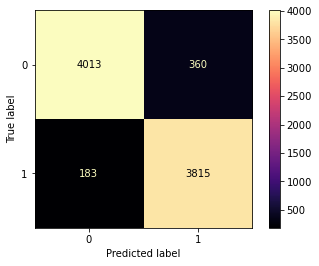

In [13]:
# Tuning the model
param_grid = {'alpha': [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(tfidf_train, y_train)

# Best parameters from grid search
best_alpha = grid.best_params_['alpha']
print(f'Best alpha parameter: {best_alpha}')

# Refit the model with the best parameter
nb_best = MultinomialNB(alpha=best_alpha)
nb_best.fit(tfidf_train, y_train)

# Predictions with the tuned model
y_pred_best = nb_best.predict(tfidf_test)

# Evaluation of the tuned model
print('Classification Report (Tuned Model):\n')
print(classification_report(y_test, y_pred_best, target_names=['Real', 'Fake']))

print('Confusion Matrix (Tuned Model):\n')
print(confusion_matrix(y_test, y_pred_best))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, labels=nb_best.classes_, cmap='magma')

## Pipeline - Final Solution

Best parameters: {'nb__alpha': 0.07, 'tfidf__max_df': 0.75, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
Classification Report (Tuned Model):

              precision    recall  f1-score   support

        Real       0.95      0.95      0.95      4373
        Fake       0.95      0.95      0.95      3998

    accuracy                           0.95      8371
   macro avg       0.95      0.95      0.95      8371
weighted avg       0.95      0.95      0.95      8371

Confusion Matrix (Tuned Model):

[[4154  219]
 [ 210 3788]]


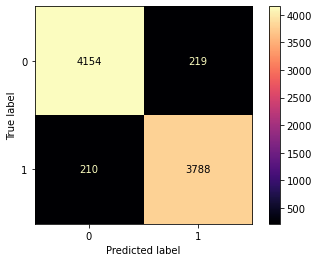

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['fakenews'],
                                                    test_size=0.2, random_state=42, stratify=df['fakenews'])

# Define a pipeline combining TfidfVectorizer and MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set up the parameter grid for TfidfVectorizer and MultinomialNB
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams or unigrams + bigrams
    'tfidf__max_df': [0.75, 1.0],  # Maximum document frequency
    'tfidf__min_df': [1, 2],  # Minimum document frequency
    'tfidf__max_features': [None, 5000, 10000],  # Limit on the number of features
    'tfidf__stop_words': ['english'],  # Stop words
    'nb__alpha': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],  # Alpha values for smoothing
}

# Perform grid search with cross-validation
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Best parameters from grid search
print(f'Best parameters: {grid.best_params_}')

# Refit the model with the best parameters
best_model = grid.best_estimator_

# Predictions with the tuned model
y_pred_best = best_model.predict(X_test)

# Evaluation of the tuned model
print('Classification Report (Tuned Model):\n')
print(classification_report(y_test, y_pred_best, target_names=['Real', 'Fake']))

print('Confusion Matrix (Tuned Model):\n')
print(confusion_matrix(y_test, y_pred_best))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, labels=best_model.named_steps['nb'].classes_, cmap='magma')

In [15]:
# Analyze the most influential words
vectorizer = best_model.named_steps['tfidf']
nb_model = best_model.named_steps['nb']

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get feature log probabilities
feature_log_prob = nb_model.feature_log_prob_

n_top_words = 10

for i, class_label in enumerate(nb_model.classes_):
    top_feature_indices = np.argsort(feature_log_prob[i])[-n_top_words:]
    top_features = feature_names[top_feature_indices]
    print(f"\nTop {n_top_words} words for class '{class_label}':")
    for word in top_features:
        print(word)


Top 10 words for class '0':
round
today
zamalek
ontimenew
egyptian
leagu
club
alahli
match
team

Top 10 words for class '1':
play
player
say
goal
refer
god
zamalek
leagu
alahli
haha


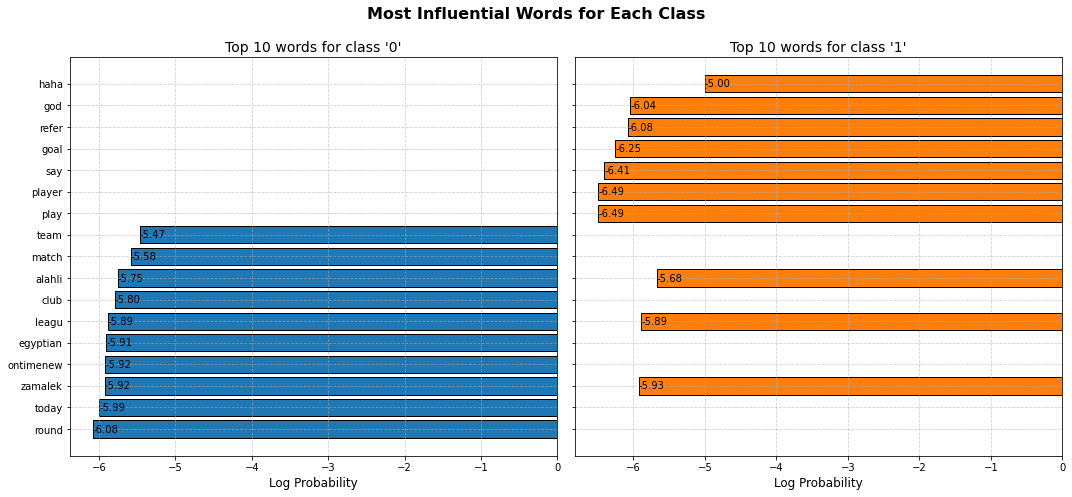

In [16]:
# Analyze the most influential words
vectorizer = best_model.named_steps['tfidf']
nb_model = best_model.named_steps['nb']

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get feature log probabilities
feature_log_prob = nb_model.feature_log_prob_

# Find the top 10 most influential words for each class
n_top_words = 10

# Initialize the plot
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

colors = ['#1f77b4', '#ff7f0e']  # Colors for each class

for i, class_label in enumerate(nb_model.classes_):
    top_feature_indices = np.argsort(feature_log_prob[i])[-n_top_words:]
    top_features = feature_names[top_feature_indices]
    top_scores = feature_log_prob[i][top_feature_indices]

    # Plot the bar chart
    bars = axes[i].barh(top_features, top_scores, color=colors[i], edgecolor='black')
    axes[i].set_title(f"Top {n_top_words} words for class '{class_label}'", fontsize=14)
    axes[i].set_xlabel('Log Probability', fontsize=12)
    axes[i].invert_yaxis()
    axes[i].grid(True, linestyle='--', alpha=0.6)

    # Annotate bars with their log probabilities
    for bar in bars:
        width = bar.get_width()
        axes[i].text(width, bar.get_y() + bar.get_height() / 2,
                     f'{width:.2f}', ha='left', va='center', fontsize=10, color='black')

# Set the main title and adjust layout
fig.suptitle('Most Influential Words for Each Class', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.88)
plt.show()

## We are saving the best model.

In [17]:
# Best parameters
best_params = {
    'nb__alpha': 0.06,
    'tfidf__max_df': 0.75,
    'tfidf__max_features': None,
    'tfidf__min_df': 1,
    'tfidf__ngram_range': (1, 2),
    'tfidf__stop_words': 'english'
}

# Define the pipeline with the best parameters
best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=best_params['tfidf__max_df'],
                              max_features=best_params['tfidf__max_features'],
                              min_df=best_params['tfidf__min_df'],
                              ngram_range=best_params['tfidf__ngram_range'],
                              stop_words=best_params['tfidf__stop_words'])),
    ('nb', MultinomialNB(alpha=best_params['nb__alpha']))
])

# Fit the pipeline with the training data
best_pipeline.fit(X_train, y_train)

# Save the model to a file
model_filename = 'best_text_classification_model.joblib'
joblib.dump(best_pipeline, model_filename)

print(f'Model saved to {model_filename}')

Model saved to best_text_classification_model.joblib
